### Load the necessary packages

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

from torch_lr_finder import LRFinder

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
  pip install torch-lr-finder -v --global-option="amp"


### Initalize parameters

In [44]:
# Location of data
data_dir = '../data/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'
test_dir = data_dir + 'test/'

save_file_name = 'resnet50-transfer10.pt'
checkpoint_file_name = 'resnet50-transfer10.pth'

# Change to fit hardware
batch_size = 32

image_size = 224

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [3]:
# set random seeds
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

### Image Augmentation

In [35]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=image_size),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(45),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.CenterCrop(size=image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.CenterCrop(size=image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Data Iterators

In [36]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valid_dir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

### Model Setup
#### Load Pre-trained ResNet50Model

In [6]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Freeze weights of early layers of the VGG16 Model

In [7]:
for param in model.parameters():
    param.requires_grad = False

#### Replace Last layer with fully connected layer configured for the task at hand

In [8]:
n_classes = 101

n_inputs = model.fc.in_features

classifier = nn.Sequential(
    nn.Linear(n_inputs,image_size),
    nn.LeakyReLU(),
    nn.Linear(image_size,n_classes)
    )

model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Move model to GPU

In [9]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

#### Mapping of food labels to indexes

In [10]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'apple_pie'),
 (1, 'baby_back_ribs'),
 (2, 'baklava'),
 (3, 'beef_carpaccio'),
 (4, 'beef_tartare'),
 (5, 'beet_salad'),
 (6, 'beignets'),
 (7, 'bibimbap'),
 (8, 'bread_pudding'),
 (9, 'breakfast_burrito')]

### Finding the Right Learning Rate

In order to use a Cyclic Learning Rate scheduler efficiently, you must first find the bounds between the upper and lower limit learning rates.

In [11]:
# # we will be using negative log likelihood as the loss function
# criterion = nn.CrossEntropyLoss()
# # we will be using the SGD optimizer as our optimizer
# optimizer = optim.SGD(model.fc.parameters(), lr=1e-4)
# lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
# lr_finder.range_test(dataloaders['train'], end_lr=1, num_iter=2500)
# lr_finder.plot()
# lr_finder.reset()

In [12]:
# # we will be using negative log likelihood as the loss function
# criterion = nn.CrossEntropyLoss()
# # we will be using the SGD optimizer as our optimizer
# optimizer = optim.SGD(model.parameters(), lr=1e-4)
# lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
# lr_finder.range_test(dataloaders['train'], end_lr=1, num_iter=2500)
# lr_finder.plot()
# lr_finder.reset()

### Training Loss and Optimizer

In [13]:
# we will be using negative log likelihood as the loss function
criterion = nn.CrossEntropyLoss()
# we will be using the Adam optimizer as our optimizer
optimizer = optim.SGD(model.fc.parameters(), lr=1e-1, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs 
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, max_lr=1e-1, base_lr=1e-3, mode='triangular')

In [ ]:
def train_model(model,
                criterion,
                optimizer,
                scheduler,
                train_loader,
                valid_loader,
                save_file_name,
                checkpoint_file_name,
                early_stopping_patience=100,
                overfit_patience=15,
                n_epochs=25,
                print_every=2,
                valid_every=2
               ):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    # early stopping initializaiton
    epochs_no_improve = 0
    epochs_overfit = 0
    valid_loss_min = np.Inf
    
    valid_max_acc = 0
    history = []
    
    # number of epochs already trained (if using loaded in model weights)
    try:
        print("Model has been trained for: {} epochs.\n".format(model.epochs))
    except:
        model.epochs = 0
        print("Starting training from scratch.\n")
        
    overall_start = timer()
    
    #Main loop
    for epoch in range(n_epochs):
        
        #keep track of training and validation loss of each epoch
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0
        valid_acc = 0
        
        #set to training
        model.train()
        start = timer()
        
        # training loop
        for ii, (data, target) in enumerate(train_loader):
            #tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
                
            # clear gradients
            optimizer.zero_grad()
            #predicted outpouts are log probabilities
            output = model(data)
            
            # loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()
            
            # update the parameters
            optimizer.step()
            
            # track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
            
            # calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)
            
            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')
        # after training loop ends
        else:
            model.epochs += 1
            
            if model.epochs > 1 and (model.epochs % valid_every == 0): 
                # don't need to keep track of gradients
                with torch.no_grad():
                    # set to evaluation mode
                    model.eval()

                    #validation loop
                    for data, target in valid_loader:
                        #tensors to gpu
                        if train_on_gpu:
                            data, target = data.cuda(), target.cuda()

                        # Forward pass
                        output = model(data)

                        # validation loss 
                        loss = criterion(output, target)
                        # multiply average loss times the number of examples in batch
                        valid_loss += loss.item() * data.size(0)

                        # calculate validation accuracy
                        _, pred = torch.max(output, dim=1)
                        correct_tensor = pred.eq(target.data.view_as(pred))
                        accuracy = torch.mean(
                            correct_tensor.type(torch.FloatTensor))
                        # multiply average accuracy times the number of examples
                        valid_acc += accuracy.item() * data.size(0)

                    # calculate average losses
                    train_loss = train_loss / (len(train_loader.dataset))
                    valid_loss = valid_loss / (len(valid_loader.dataset))

                    # calculate average accuracy
                    train_acc = train_acc / (len(train_loader.dataset))
                    valid_acc = valid_acc / (len(valid_loader.dataset))

                    # learning rate scheduler step
                    scheduler.step(valid_loss)

                    history.append([train_loss, valid_loss, train_acc, valid_acc, model.epochs])

                    # Print training and validation results
                    if (model.epochs + 1) % valid_every == 0:
                        print(
                            f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                        )
                        print(
                            f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                        )

                    # save the model if validation loss decreases
                    if valid_loss < valid_loss_min:
                        print("Valid loss decreased ({:.6f} --> {:.6f}). Saving model...".format(valid_loss_min, valid_loss))

                        # save model
                        torch.save(model.state_dict(), save_file_name)

                        checkpoint = {
                            "model": model,
                            "criterion": criterion,
                            "epochs": model.epochs,
                            "optimizer_state": optimizer.state_dict(),
                            "model_state": model.state_dict(),
                            "valid_loss_min": valid_loss
                        }
                        torch.save(checkpoint, checkpoint_file_name)

                        # track improvements
                        epochs_no_improve = 0
                        epochs_overfit = 0
                        valid_loss_min = valid_loss
                        valid_best_acc = valid_acc
                        best_epoch = epoch

                    # otherwise increment count of epochs with no improvement
                    elif train_loss < valid_loss:
                        epochs_overfit += 1
                        if epochs_overfit >= overfit_patience:
                            print(f'\n Valid loss has increased larger than training loss for {epochs_overfit} epochs')
                            print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                            )
                            # load the best state dict
                            model.load_state_dict(torch.load(save_file_name))
                            # attach the optimizer
                            model.optimizer = optimizer

                            # format history
                            history = pd.DataFrame(
                                    history,
                                    columns=[
                                        'train_loss', 'valid_loss', 'train_acc',
                                        'valid_acc', 'epochs'
                                    ])
                            return model, history

                    else:
                        epochs_no_improve += 1
                        #trigger early stopping
                        # this should be not going bad
                        if (epochs_no_improve >= early_stopping_patience):
                            print(
                                f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                            )
                            total_time = timer() - overall_start
                            print(
                                f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                            )

                            # load the best state dict
                            model.load_state_dict(torch.load(save_file_name))
                            # attach the optimizer
                            model.optimizer = optimizer

                            # format history
                            history = pd.DataFrame(
                                    history,
                                    columns=[
                                        'train_loss', 'valid_loss', 'train_acc',
                                        'valid_acc', 'epochs'
                                    ])
                            return model, history
                        
    model.optimizer = optimizer
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (model.epochs):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [15]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    checkpoint_file_name=checkpoint_file_name,
    early_stopping_patience=50,
    overfit_patience=10,
    n_epochs=200,
    print_every=1
    )

Starting training from scratch.

Epoch: 1	100.00% complete. 708.11 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 3.7033 	Validation Loss: 3.2606
		Training Accuracy: 21.49%	 Validation Accuracy: 26.83%
Valid loss decreased (inf --> 3.260641). Saving model...
Epoch: 3	100.00% complete. 713.82 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 2.9746 	Validation Loss: 2.6674
		Training Accuracy: 30.42%	 Validation Accuracy: 35.74%
Valid loss decreased (3.260641 --> 2.667352). Saving model...
Epoch: 5	100.00% complete. 710.21 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 2.7804 	Validation Loss: 2.5093
		Training Accuracy: 34.15%	 Validation Accuracy: 38.37%
Valid loss decreased (2.667352 --> 2.509253). Saving model...
Epoch: 7	100.00% complete. 710.25 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 2.6872 	Validation Loss: 2.4001
		Training Accuracy: 35.74%	 Validation Accuracy: 40.36%
Valid loss decreased (2.509253 --> 2.400139). Saving model...
Epoch: 9	100.00% complete. 7

Epoch: 77	100.00% complete. 709.82 seconds elapsed in epoch.
Epoch: 77 	Training Loss: 2.2384 	Validation Loss: 1.9885
		Training Accuracy: 45.23%	 Validation Accuracy: 49.35%
Epoch: 79	100.00% complete. 709.18 seconds elapsed in epoch.
Epoch: 79 	Training Loss: 2.2320 	Validation Loss: 2.0272
		Training Accuracy: 45.20%	 Validation Accuracy: 48.68%
Epoch: 81	100.00% complete. 708.44 seconds elapsed in epoch.
Epoch: 81 	Training Loss: 2.2267 	Validation Loss: 1.9621
		Training Accuracy: 45.53%	 Validation Accuracy: 49.93%
Valid loss decreased (1.976253 --> 1.962081). Saving model...
Epoch: 83	100.00% complete. 709.50 seconds elapsed in epoch.
Epoch: 83 	Training Loss: 2.2320 	Validation Loss: 1.9945
		Training Accuracy: 45.39%	 Validation Accuracy: 49.33%
Epoch: 85	100.00% complete. 707.23 seconds elapsed in epoch.
Epoch: 85 	Training Loss: 2.2220 	Validation Loss: 1.9673
		Training Accuracy: 45.46%	 Validation Accuracy: 49.86%
Epoch: 87	100.00% complete. 708.93 seconds elapsed in epoc

Valid loss decreased (1.891438 --> 1.871782). Saving model...
Epoch: 163	100.00% complete. 707.40 seconds elapsed in epoch.
Epoch: 163 	Training Loss: 2.1052 	Validation Loss: 1.8869
		Training Accuracy: 47.97%	 Validation Accuracy: 51.90%
Epoch: 165	100.00% complete. 713.18 seconds elapsed in epoch.
Epoch: 165 	Training Loss: 2.0978 	Validation Loss: 1.9131
		Training Accuracy: 48.13%	 Validation Accuracy: 51.42%
Epoch: 167	100.00% complete. 707.75 seconds elapsed in epoch.
Epoch: 167 	Training Loss: 2.0963 	Validation Loss: 1.9046
		Training Accuracy: 48.00%	 Validation Accuracy: 51.74%
Epoch: 169	100.00% complete. 706.99 seconds elapsed in epoch.
Epoch: 169 	Training Loss: 2.0974 	Validation Loss: 1.9089
		Training Accuracy: 47.91%	 Validation Accuracy: 51.86%
Epoch: 171	100.00% complete. 707.28 seconds elapsed in epoch.
Epoch: 171 	Training Loss: 2.0900 	Validation Loss: 1.9086
		Training Accuracy: 48.15%	 Validation Accuracy: 51.99%
Epoch: 173	100.00% complete. 707.63 seconds elap

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

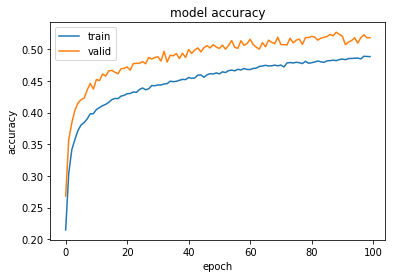

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

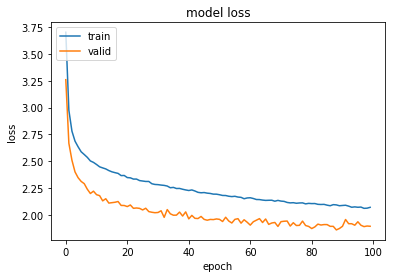

In [29]:

# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('train_valid_accuracy.png')
plt.show()


# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('train_valid_loss.png')

plt.show()


In [19]:
# we will be using negative log likelihood as the loss function
criterion = nn.CrossEntropyLoss()
# we will be using the Adam optimizer as our optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

# secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs 
# then lower the learning rate by 0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, max_lr=1e-1, base_lr=1e-3, mode='triangular')

In [31]:
for param in model.parameters():
    param.requires_grad = True

In [32]:
torch.cuda.empty_cache()

In [41]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    checkpoint_file_name=checkpoint_file_name,
    early_stopping_patience=50,
    overfit_patience=10,
    n_epochs=200,
    print_every=1
    )

Model has been trained for: 224 epochs.

Epoch: 1	100.00% complete. 1355.44 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.8272 	Validation Loss: 1.0429
		Training Accuracy: 77.49%	 Validation Accuracy: 73.89%
Valid loss decreased (inf --> 1.042851). Saving model...
Epoch: 3	100.00% complete. 1345.83 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.7998 	Validation Loss: 1.0797
		Training Accuracy: 78.09%	 Validation Accuracy: 73.20%
Epoch: 5	100.00% complete. 1342.95 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.7798 	Validation Loss: 1.0316
		Training Accuracy: 78.69%	 Validation Accuracy: 74.18%
Valid loss decreased (1.042851 --> 1.031629). Saving model...
Epoch: 7	100.00% complete. 1336.51 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.7614 	Validation Loss: 1.0605
		Training Accuracy: 79.20%	 Validation Accuracy: 73.61%
Epoch: 9	100.00% complete. 1339.84 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.7289 	Validation Loss: 1.0233
		Training Accuracy: 7

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

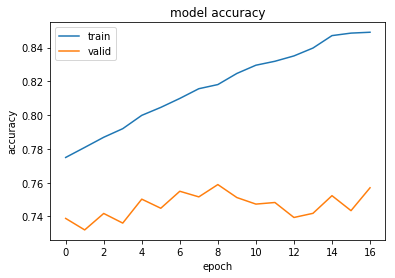

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

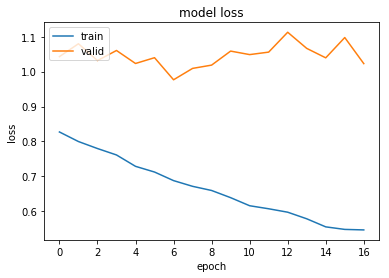

In [43]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['valid_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['valid_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()